In [1]:
import os
import sys
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

from datetime import timedelta
from multiprocessing import cpu_count
from torchvision.utils import make_grid
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

In [2]:
SEED = 42

os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

GPU = 0

device = torch.device(f'cuda:{GPU}' if torch.cuda.is_available() else 'cpu')

In [3]:
!wget http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar -P data/

--2021-06-06 14:28:07--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2021-06-06 14:28:08--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘data/VOCtrainval_11-May-2012.tar’

VOCtrainval_11-May- 100%[===================>]   1.86G  68.4MB/s    in 28s     

2021-06-06 14:28:36 (67.4 MB/s) - ‘data/VOCtrainval_11-May-2012.tar’ saved [1999639040/1999639040]



In [4]:
!tar -xf data/VOCtrainval_11-May-2012.tar -C data/
!rm -rf data/PASCAL_VOC.zip data/VOCtrainval_11-May-2012.tar

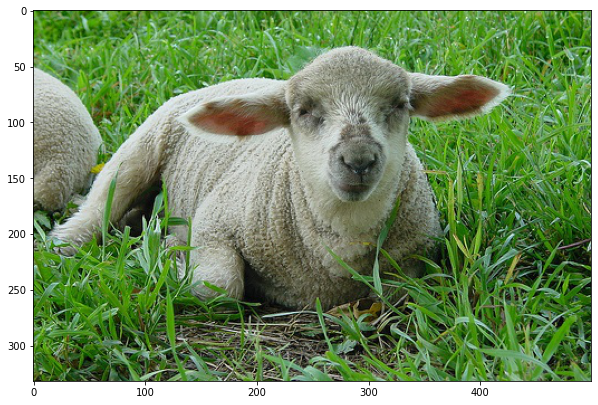

In [5]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

image_path = '/content/data/VOCdevkit/VOC2012/JPEGImages/2007_000175.jpg'

image = Image.open(image_path).convert("RGB")

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()
plt.close()

In [6]:
xml = open(os.path.join('/content/data/VOCdevkit/VOC2012/Annotations/2011_003353.xml'), "r")
tree = Et.parse(xml)
root = tree.getroot()

size = root.find("size")

width = size.find("width").text
height = size.find("height").text
channels = size.find("depth").text

print("Image properties\nwidth : {}\nheight : {}\nchannels : {}\n".format(width, height, channels))

objects = root.findall("object")
print("Objects Description")
for _object in objects:
        name = _object.find("name").text

        bndbox = _object.find("bndbox")
        xmin = bndbox.find("xmin").text
        ymin = bndbox.find("ymin").text
        xmax = bndbox.find("xmax").text
        ymax = bndbox.find("ymax").text


        print("class : {}\nxmin : {}\nymin : {}\nxmax : {}\nymax : {}\n".format(name, xmin, ymin, xmax, ymax))


Image properties
width : 375
height : 500
channels : 3

Objects Description
class : person
xmin : 130
ymin : 45.70000076293945
xmax : 375
ymax : 470



In [7]:
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree

ann_root, ann_dir, ann_files = next(os.walk(os.path.join('/content/data/VOCdevkit/VOC2012/Annotations')))
f = open('/content/data/VOCdevkit/VOC2012/voc.names', 'w')
li = []

for xml_file in ann_files:

    xml = open(os.path.join(ann_root, xml_file), "r")
    tree = Et.parse(xml)
    root = tree.getroot()


    objects = root.findall("object")

    for _object in objects:
        name = _object.find("name").text
        if name not in li:
          print(name)
          li.append(name)
          f.write(name)
          f.write("\n")

print("문제없음!")
f.close()
    #plt.figure(figsize=(10,10))
    #plt.imshow(image)
    #plt.show()
    #plt.close()

person
train
dog
tvmonitor
chair
bird
motorbike
pottedplant
aeroplane
bicycle
bus
car
diningtable
sofa
bottle
cat
sheep
cow
horse
boat
문제없음!


In [8]:
!mkdir convert2Yolo
%cd convert2Yolo
!git init
!git remote add origin https://github.com/ssaru/convert2Yolo.git
!git pull origin master
!pip3 install -r requirements.txt

/content/convert2Yolo
Initialized empty Git repository in /content/convert2Yolo/.git/
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 202 (delta 4), reused 6 (delta 4), pack-reused 188
Receiving objects: 100% (202/202), 1000.23 KiB | 7.58 MiB/s, done.
Resolving deltas: 100% (87/87), done.
From https://github.com/ssaru/convert2Yolo
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 2.2MB 7.0MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
     |████████████████████████████████| 12.6MB 23.4MB/s 
     |████████████████████████████████| 4.9MB 51.5MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 215kB 52.8MB/s 
     |████████████████████████████████| 512kB 51.8MB/s 
  Created wheel for numpy: filename=numpy-1.14.3-cp37-cp37m-linux_x86_64.whl size=7

In [9]:
from convert2Yolo.Format import YOLO as yoloYOLO
from convert2Yolo.Format import VOC as yoloVOC


class VOC(Dataset):

    IMAGE_FOLDER = "JPEGImages"
    LABEL_FOLDER = "Annotations"
    IMG_EXTENSIONS = '.jpg'

    def __init__(self, root, class_path, transform, train=True, resize=112):
        self.root = root
        self.transform = transform
        self.train = train
        self.resize_factor = resize
        self.class_path = class_path
        self.data = self.cvtData()
        print(len(self.data))


    def cvtData(self):

        result = []
        voc = yoloVOC()

        yolo = yoloYOLO(os.path.abspath(self.class_path))
        flag, self.dict_data =voc.parse(os.path.join(self.root, self.LABEL_FOLDER))

        if flag == True:
            flag, data =yolo.generate(self.dict_data)

            keys = list(data.keys())
            keys = sorted(keys, key=lambda key: int(key.split("_")[-1]))

            for key in keys:
                contents = list(filter(None, data[key].split("\n")))
                target = []
                for i in range(len(contents)):
                    tmp = contents[i]
                    tmp = tmp.split(" ")
                    for j in range(len(tmp)):
                        tmp[j] = float(tmp[j])
                    target.append(tmp)

                result.append({os.path.join(self.root, self.IMAGE_FOLDER, "".join([key, self.IMG_EXTENSIONS])) : target})

            return result


    def __getitem__(self, index):

        key = list(self.data[index].keys())[0]
        img = Image.open(key).convert('RGB')
        current_shape = img.size
        img = img.resize((self.resize_factor, self.resize_factor))
        target = self.data[index][key]
        img = self.transform(img)

        return img, target, current_shape


    def __len__(self):
        return len(self.data)

In [10]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = VOC(root='/content/data/VOCdevkit/VOC2012/',
                    class_path = '/content/data/VOCdevkit/VOC2012/voc.names',
                    transform=transform)



VOC Parsing:   |████████████████████████████████████████| 100.0% (17125/17125)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (17125/17125)  Complete

17125


In [11]:
def detection_collate(batch):
    targets = []
    imgs = []
    sizes = []

    for sample in batch:
        imgs.append(sample[0])
        sizes.append(sample[2])

        np_label = np.zeros((7, 7, 6), dtype=np.float32)
        for object in sample[1]:
            objectness = 1
            classes = object[0]
            x_ratio = object[1]
            y_ratio = object[2]
            w_ratio = object[3]
            h_ratio = object[4]

            scale_factor = (1 / 7)
            grid_x_index = int(x_ratio // scale_factor)
            grid_y_index = int(y_ratio // scale_factor)
            x_offset = (x_ratio / scale_factor) - grid_x_index
            y_offset = (y_ratio / scale_factor) - grid_y_index

            np_label[grid_x_index][grid_y_index] = np.array([objectness, x_offset, y_offset, w_ratio, h_ratio, classes])

        label = torch.from_numpy(np_label)
        targets.append(label)
    return torch.stack(imgs, 0), torch.stack(targets, 0), sizes

In [12]:
tr_idx, val_idx = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=SEED)

In [13]:
tr_sampler = SubsetRandomSampler(tr_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [14]:
import torch.utils.data as data

train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=20,
    sampler=tr_sampler,
    collate_fn=detection_collate,
    num_workers = 0)
val_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=20,
    sampler=val_sampler,
    collate_fn=detection_collate,
    num_workers = 0)


In [15]:
class Net(nn.Module):
    def __init__(self, params):

        self.dropout_prop = params["dropout"]
        self.num_classes = params["num_class"]

        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(192, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(128, momentum=0.01),
            nn.LeakyReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=1),
            nn.BatchNorm2d(256, momentum=0.01),
            nn.LeakyReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512, momentum=0.01),
            nn.LeakyReLU())
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer9 = nn.Sequential(
            nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024, momentum=0.01),
            nn.LeakyReLU())

        self.fc1 = nn.Sequential(
            nn.Linear(3 * 3 * 1024, 4096),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout_prop)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 7 * 7 * ((5) + self.num_classes))
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        #print("9번째 레이어", x.size())
        
        x = x.reshape(x.size(0), -1)
        #print("reshape 이후", x.size())
        x = self.fc1(x)
        #print("fc1 연산 후", x.size())
        out = self.fc2(x)
        #print("fc2 연산 후", x.size())
        out = out.reshape((-1, 7, 7, ((5) + self.num_classes)))
        out[:, :, :, 0] = torch.sigmoid(out[:, :, :, 0])  # sigmoid 오브젝트
        out[:, :, :, 5:] = torch.sigmoid(out[:, :, :, 5:])  # sigmoid 클래스
        #print("out은", end=' ')
        #print(out.size())
        return out


In [16]:
def one_hot(output, label, device):

    label = label.cpu().data.numpy()
    b, s1, s2, c = output.shape
    dst = np.zeros([b, s1, s2, c], dtype=np.float32)

    for k in range(b):
        for i in range(s1):
            for j in range(s2):

                dst[k][i][j][int(label[k][i][j])] = 1.

    result = torch.from_numpy(dst)
    if device == 'cpu':
        result = result.type(torch.FloatTensor)
    else:
        result = result.type(torch.FloatTensor).cuda()

    return result

In [17]:
def loss_yolo(output, target, device):

    b, _, _, _ = target.shape
    _, _, _, n = output.shape

    lambda_coord = 5
    lambda_noobj = 0.5

    #아웃풋 데이터 slicing
    obj_output = output[:, :, :, 0]
    x_offset_output = output[:, :, :, 1]
    y_offset_output = output[:, :, :, 2]
    width_output = output[:, :, :, 3]
    height_output = output[:, :, :, 4]
    class_output = output[:, :, :, 5:]

    num_cls = class_output.shape[-1]

    # 라벨 데이터 slicing
    obj_label = target[:, :, :, 0]
    x_offset_label = target[:, :, :, 1]
    y_offset_label = target[:, :, :, 2]
    width_label = target[:, :, :, 3]
    height_label = target[:, :, :, 4]
    class_label = one_hot(class_output, target[:, :, :, 5], device)

    no_obj_label = torch.neg(torch.add(obj_label, -1))

    obj_coord_loss = lambda_coord * torch.sum(obj_label *
                        (torch.pow(x_offset_output - x_offset_label, 2) +
                                    torch.pow(y_offset_output - y_offset_label, 2)))

    obj_size_loss = lambda_coord * torch.sum(obj_label *
                               (torch.pow(width_output - torch.sqrt(width_label), 2) +
                                torch.pow(height_output - torch.sqrt(height_label), 2)))

    object_cls_map = obj_label.unsqueeze(-1)


    for i in range(num_cls - 1):
        object_cls_map = torch.cat((object_cls_map, obj_label.unsqueeze(-1)), 3)

    obj_class_loss = torch.sum(object_cls_map * torch.pow(class_output - class_label, 2))

    no_obj_loss = lambda_noobj * torch.sum(no_obj_label * torch.pow(obj_output - obj_label, 2))
    obj_loss = torch.sum(obj_label * torch.pow(obj_output - obj_label, 2))

    total_loss = (obj_coord_loss + obj_size_loss + obj_class_loss + no_obj_loss + obj_loss)
    total_loss = total_loss / b

    return total_loss

In [18]:
model = Net(params={"dropout": 0.5, "num_class": 20})
model = model.to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

In [ ]:
epochs = 20
total_step = len(train_loader)
total_train_step = epochs * total_step


for epoch in range(epochs):

    train_loss = 0
    for i, (images, labels, sizes) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).to(device)

        # Loss 계산
        train_loss = loss_yolo(outputs, labels, device.type)
        train_loss.backward()
        optimizer.step()


    valid_loss = 0
    with torch.no_grad():
        for i, (images, labels, sizes) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images).to(device)
            val_loss = loss_yolo(outputs, labels, device.type)  

    print(
        'epoch: [{}/{}], lr: {}, train_loss: {:.4f}, val_loss: {:.4f}'
        .format(epoch + 1, epochs, ([param_group['lr'] for param_group in optimizer.param_groups])[0], train_loss, val_loss))


epoch: [1/20], lr: 0.01, train_loss: 20.1739, val_loss: 1157.5538


In [ ]:
torch.save(model.state_dict(), '/content/model.pt')

In [ ]:
print('state_dict format of the model: {}'.format(model.state_dict()))